# World Trade: Queries with Spark

<b> Spark Web UI: </b> http://localhost:4040/


## Introduction

This notebook contains a number of query examples on the compiled trade dataset, stored in parquet files, showcasing common ETL-like operations and analyses such as generating columns, filtering, converting data types, aggregations, joining tables, pivots, calculating ranks, finding the top 10 of something, etc.

### Data

This dataset consists of monthly data on bilateral trade flows between all EU countries and all other countries on the globe for the last 20 years plus metadata, compiled from data downloaded from [Eurostat's COMEXT database] with scripts in the notebook `convert-data-to-parquet.ipynb`. This dataset is about 60 GB large.


## Imports

In [1]:
# Initialization and configuration
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession

# Spark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Initialize and configure Spark

In [2]:
# Configuration
conf = SparkConf().setAppName("WorldTrade").setMaster("local[4]")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g") 
conf.set("spark.executor.pyspark.memory", "2g")

# Initialization
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
spark = SparkSession(sc)

## Load and prepare data

The dataset consists of the following DataFrames:
* Fact tables: `flows`
* Dimension tables: `reporters`, `partners`, `products`

### Flows (year 2018, aggregated to yearly values)

Most query examples use this cached DataFrame instead of reading from all parquet files on my SSD drive to speed things up.

In [3]:
flows = spark.read.parquet("data/parquet/*")
flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("YEAR", "REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR").agg({"VALUE_IN_EUROS": "sum"}) \
    .groupBy("YEAR", "REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "YEAR").pivot("FLOW", [1, 2]).sum("sum(VALUE_IN_EUROS)") \
    .withColumnRenamed("1", "IMPORTS").withColumnRenamed("2", "EXPORTS") \
    .cache()

In [4]:
flows.show(10)

+----+--------+------------+-------+-----------+----------+----------+----+-------+-------+
|YEAR|REPORTER|REPORTER_ISO|PARTNER|PARTNER_ISO|TRADE_TYPE|PRODUCT_NC|YEAR|IMPORTS|EXPORTS|
+----+--------+------------+-------+-----------+----------+----------+----+-------+-------+
|2018|       1|          FR|      3|         NL|         I|  94051091|2018|1534458| 573191|
|2018|       1|          FR|      7|         IE|         I|  25223000|2018|   null| 213320|
|2018|       1|          FR|      9|         GR|         I|  10051015|2018| 342378|9670677|
|2018|       1|          FR|     30|         SE|         I|  61142000|2018|  10248| 199622|
|2018|       1|          FR|     54|         LV|         I|  39119019|2018|   2005|  28602|
|2018|       1|          FR|     55|         LT|         I|  87037000|2018|   null|   3781|
|2018|       1|          FR|    212|         TN|         E|  70071190|2018|   6476|   7426|
|2018|       1|          FR|    248|         SN|         E|  16041390|2018|   nu

In [5]:
flows.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- REPORTER: integer (nullable = true)
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER: integer (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- PRODUCT_NC: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- IMPORTS: long (nullable = true)
 |-- EXPORTS: long (nullable = true)



In [6]:
# Number of observations (reporter-partner-product-year tuples)
flows.count()

6787984

In [7]:
# Number of reporting countries
flows.select("REPORTER").distinct().count()

28

In [8]:
# Number of trade partners
flows.select("PARTNER").distinct().count()

246

In [9]:
# Number of distinct products
flows.select("PRODUCT_NC").distinct().count()

9965

### Reporters

In [10]:
schema = StructType([
    StructField("REPORTER", IntegerType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("REPORTER_NAME", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("_c2", StringType(), True)
])

reporters = spark.read.csv("data/REPORTERS.txt", sep="\t", header=False, schema=schema)
reporters = reporters \
    .select("REPORTER", "REPORTER_NAME") \
    .withColumn("REPORTER_NAME", F.trim(reporters["REPORTER_NAME"])) \
    .cache()   

In [11]:
reporters.show(10)

+--------+-------------+
|REPORTER|REPORTER_NAME|
+--------+-------------+
|       1|       France|
|       2|  Belg.-Luxbg|
|       3|  Netherlands|
|       4|   Fr Germany|
|       5|        Italy|
|       6| Utd. Kingdom|
|       7|      Ireland|
|       8|      Denmark|
|       9|       Greece|
|      10|     Portugal|
+--------+-------------+
only showing top 10 rows



In [12]:
# Number of reporters
reporters.count()

29

### Partners

The operation `partners.filter(partners["END_DATE"] == "31/12/2500")` removes countries or territories that don't exist as legal entities anymore.

In [13]:
schema = StructType([
    StructField("PARTNER", IntegerType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("PARTNER_NAME", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("_c2", StringType(), True)
])

partners = spark.read.csv("data/PARTNERS.txt", sep="\t", header=False, schema=schema)
partners = partners.filter(partners["END_DATE"] == "31/12/2500") \
    .withColumn("PARTNER_NAME", F.trim(partners["PARTNER_NAME"])) \
    .select("PARTNER", "PARTNER_NAME") \
    .cache()

In [14]:
partners.show(10)

+-------+--------------+
|PARTNER|  PARTNER_NAME|
+-------+--------------+
|      1|        France|
|      3|   Netherlands|
|      4|       Germany|
|      5|         Italy|
|      6|United Kingdom|
|      7|       Ireland|
|      8|       Denmark|
|      9|        Greece|
|     10|      Portugal|
|     11|         Spain|
+-------+--------------+
only showing top 10 rows



In [15]:
# Number of partners
partners.count()

249

### Product codes (Combined Nomenclature & Harmonized System)

The traded goods in this sample of the dataset are classified according to two systems: The Harmonized System and the Combined Nomenclature. The Harmonized System at the 2-digit level used here distinguishes between about 100 product categories; the Combined Nomenclature at the 8-digit level used here between about 30,000 products. For more on these systems see:
* Harmonized System: https://en.wikipedia.org/wiki/Harmonized_System
* Combined Nomenclature: https://en.wikipedia.org/wiki/Combined_Nomenclature

In [16]:
schema = StructType([
    StructField("PRODUCT_NC", StringType(), True),
    StructField("START_DATE", StringType(), True),
    StructField("END_DATE", StringType(), True),
    StructField("_c1", StringType(), True),
    StructField("PRODUCT_NC_NAME", StringType(), True),
    StructField("_c2", StringType(), True),
    StructField("_c3", StringType(), True)   
])

products = spark.read.csv("data/CN.txt", sep="\t", header=False, schema=schema)
products = products \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME") \
    .withColumn("PRODUCT_NC_NAME", F.trim(products["PRODUCT_NC_NAME"])) \
    .withColumn("HS2", products["PRODUCT_NC"].substr(1, 2)) \
    .cache()

In [17]:
# Number of product categories (CN8)
products.count()

31154

In [18]:
products.show(10)

+----------+--------------------+---+
|PRODUCT_NC|     PRODUCT_NC_NAME|HS2|
+----------+--------------------+---+
|        01|        LIVE ANIMALS| 01|
|      0101|LIVE HORSES, ASSE...| 01|
|    010110|PURE-BRED BREEDIN...| 01|
|  01011010|PURE-BRED BREEDIN...| 01|
|  01011090|PURE-BRED BREEDIN...| 01|
|    010111|PURE-BRED BREEDIN...| 01|
|  01011100|PURE-BRED BREEDIN...| 01|
|    010119|LIVE HORSES (EXCL...| 01|
|  01011910|HORSES FOR SLAUGHTER| 01|
|  01011990|HORSES (EXCL. THO...| 01|
+----------+--------------------+---+
only showing top 10 rows



## Query examples (Spark)

### Total imports, exports, and trade balance of all EU countries in 2018

In [21]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .select("REPORTER", "REPORTER_ISO", "IMPORTS", "EXPORTS") \
    .groupby("REPORTER", "REPORTER_ISO").agg({"IMPORTS": "sum", "EXPORTS": "sum"})
query = query \
    .withColumn("IMPORTS_BN", query["sum(IMPORTS)"]/1e9) \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .withColumn("BALANCE_BN", (query["sum(Exports)"] -  query["sum(IMPORTS)"])/1e9) \
    .join(F.broadcast(reporters), "REPORTER", how="left") \
    .select("REPORTER_ISO", "REPORTER_NAME", "IMPORTS_BN", "EXPORTS_BN", "BALANCE_BN")
query.orderBy(query["BALANCE_BN"].desc()).show(50)

+------------+--------------+--------------+--------------+--------------+
|REPORTER_ISO| REPORTER_NAME|    IMPORTS_BN|    EXPORTS_BN|    BALANCE_BN|
+------------+--------------+--------------+--------------+--------------+
|          DE|    Fr Germany|1088.542025757|1320.837947576| 232.295921819|
|          NL|   Netherlands|  546.09129268| 613.142160286|  67.050867606|
|          IE|       Ireland|  91.555921454| 139.725377996|  48.169456542|
|          IT|         Italy| 423.998108363| 462.898983413|   38.90087505|
|          CZ|Czech Republic| 156.457527193| 171.260242197|  14.802715004|
|          BE|       Belgium| 381.801196443| 394.890274691|  13.089078248|
|          DK|       Denmark|  86.784856865|  92.607129939|   5.822273074|
|          HU|       Hungary| 103.057381972| 106.498438296|   3.441056324|
|          SI|      Slovenia|  35.803283225|  37.423038143|   1.619754918|
|          SK|      Slovakia|  79.544741259|  79.798991632|   0.254250373|
|          EE|       Esto

### Total German exports, imports, and trade balance in 2018

In [22]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .select("IMPORTS", "EXPORTS") \
    .agg({"IMPORTS": "sum", "EXPORTS": "sum"})
query = query \
    .withColumn("IMPORTS_BN", query["sum(IMPORTS)"]/1e9) \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .withColumn("BALANCE_BN", (query["sum(Exports)"] -  query["sum(IMPORTS)"])/1e9) \
    .select("IMPORTS_BN", "EXPORTS_BN", "BALANCE_BN")
query.show()

+--------------+--------------+-------------+
|    IMPORTS_BN|    EXPORTS_BN|   BALANCE_BN|
+--------------+--------------+-------------+
|1088.542025757|1320.837947576|232.295921819|
+--------------+--------------+-------------+



### Top 10 German export destinations in 2018

In [23]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"}) \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("PARTNER_ISO", "PARTNER_NAME", "sum(EXPORTS)")
query = query \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .select("PARTNER_ISO", "PARTNER_NAME", "EXPORTS_BN")
query.orderBy(query["EXPORTS_BN"].desc()).show(10)

+-----------+--------------------+-------------+
|PARTNER_ISO|        PARTNER_NAME|   EXPORTS_BN|
+-----------+--------------------+-------------+
|         US|United States of ...|114.480812071|
|         FR|              France|105.138035193|
|         CN|               China| 93.680024543|
|         NL|         Netherlands| 84.295499168|
|         GB|      United Kingdom| 81.773800994|
|         IT|               Italy| 69.716726283|
|         AT|             Austria| 63.726179308|
|         PL|              Poland| 63.290486866|
|         CH|         Switzerland| 53.626715897|
|         BE|             Belgium| 44.238103706|
+-----------+--------------------+-------------+
only showing top 10 rows



### Top 10 countries with the highest trade deficit with Germany in 2018 

In [24]:
query = flows \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"}) \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("PARTNER_ISO", "PARTNER_NAME", "sum(EXPORTS)")
query = query \
    .withColumn("EXPORTS_BN", query["sum(EXPORTS)"]/1e9) \
    .select("PARTNER_ISO", "PARTNER_NAME", "EXPORTS_BN")
query.orderBy(query["EXPORTS_BN"].desc()).show(10)

+-----------+--------------------+-------------+
|PARTNER_ISO|        PARTNER_NAME|   EXPORTS_BN|
+-----------+--------------------+-------------+
|         US|United States of ...|114.480812071|
|         FR|              France|105.138035193|
|         CN|               China| 93.680024543|
|         NL|         Netherlands| 84.295499168|
|         GB|      United Kingdom| 81.773800994|
|         IT|               Italy| 69.716726283|
|         AT|             Austria| 63.726179308|
|         PL|              Poland| 63.290486866|
|         CH|         Switzerland| 53.626715897|
|         BE|             Belgium| 44.238103706|
+-----------+--------------------+-------------+
only showing top 10 rows



### Top trade partners per reporter in 2018, ranked by total exports 

In [25]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .groupBy("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO").agg({"EXPORTS": "sum"})
query = query \
    .withColumn("EXPORTS_MN", query["sum(EXPORTS)"]/1e6) \
    .select("REPORTER", "REPORTER_ISO", "PARTNER", "PARTNER_ISO", "EXPORTS_MN")
query = query.withColumn("RANK", F.rank().over(
        Window.partitionBy(query["REPORTER_ISO"]).orderBy(query["EXPORTS_MN"].desc())
    )) \
    .join(F.broadcast(reporters), "REPORTER", how="left") \
    .join(F.broadcast(partners), "PARTNER", how="left") \
    .select("REPORTER_ISO", "REPORTER_NAME", "PARTNER_ISO", "PARTNER_NAME", "RANK", "EXPORTS_MN")

In [26]:
# Example: Denmark
query.filter(query["REPORTER_ISO"] == "DK").orderBy(query["RANK"]).show(10)

+------------+-------------+-----------+--------------------+----+------------+
|REPORTER_ISO|REPORTER_NAME|PARTNER_ISO|        PARTNER_NAME|RANK|  EXPORTS_MN|
+------------+-------------+-----------+--------------------+----+------------+
|          DK|      Denmark|         DE|             Germany|   1|13729.969159|
|          DK|      Denmark|         SE|              Sweden|   2|   9669.9423|
|          DK|      Denmark|         QZ|Countries and ter...|   3| 9203.425962|
|          DK|      Denmark|         GB|      United Kingdom|   4| 5888.922523|
|          DK|      Denmark|         QY|Countries and ter...|   5| 5356.035594|
|          DK|      Denmark|         NO|              Norway|   6| 5164.612013|
|          DK|      Denmark|         NL|         Netherlands|   7|  4121.74832|
|          DK|      Denmark|         US|United States of ...|   8| 3971.658074|
|          DK|      Denmark|         FR|              France|   9| 3017.698442|
|          DK|      Denmark|         CN|

In [27]:
# Example: Netherlands
query.filter(query["REPORTER_ISO"] == "NL").orderBy(query["RANK"]).show(10)

+------------+-------------+-----------+--------------------+----+------------+
|REPORTER_ISO|REPORTER_NAME|PARTNER_ISO|        PARTNER_NAME|RANK|  EXPORTS_MN|
+------------+-------------+-----------+--------------------+----+------------+
|          NL|  Netherlands|         DE|             Germany|   1|139203.49707|
|          NL|  Netherlands|         BE|             Belgium|   2|65860.847258|
|          NL|  Netherlands|         FR|              France|   3|50603.713855|
|          NL|  Netherlands|         GB|      United Kingdom|   4|48783.012722|
|          NL|  Netherlands|         US|United States of ...|   5|26576.845099|
|          NL|  Netherlands|         IT|               Italy|   6|23599.327679|
|          NL|  Netherlands|         ES|               Spain|   7|18453.018886|
|          NL|  Netherlands|         QY|Countries and ter...|   8|16394.810753|
|          NL|  Netherlands|         PL|              Poland|   9|14989.288489|
|          NL|  Netherlands|         SE|

### Exports from Argentina to Germany in 2018 by product category (CN8)

In [28]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})
query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")

In [29]:
# With truncated descriptions
query.orderBy(query["IMPORTS_MN"].desc()).show(10, truncate=True)

+----------+--------------------+----------+
|PRODUCT_NC|     PRODUCT_NC_NAME|IMPORTS_MN|
+----------+--------------------+----------+
|  26030000|COPPER ORES AND C...|198.439966|
|  02013000|FRESH OR CHILLED ...|194.604795|
|  29371900|POLYPEPTIDE HORMO...|  85.19866|
|  51052900|WOOL, COMBED (EXC...| 46.657958|
|  23040000|OILCAKE AND OTHER...| 34.440129|
|  04090000|       NATURAL HONEY| 34.256382|
|  87082990|PARTS AND ACCESSO...| 28.150679|
|  71069100|SILVER, INCL. SIL...|  27.79469|
|  23080040|ACORNS AND HORSE-...| 21.072345|
|  38231990|FATTY ACIDS, INDU...| 19.457899|
+----------+--------------------+----------+
only showing top 10 rows



In [30]:
# Without truncated descriptions
query.orderBy(query["IMPORTS_MN"].desc()).show(5, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|PRODUCT_NC|PRODUCT_NC_NAME                                                                                                                                                                                                                 |IMPORTS_MN|
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|26030000  |COPPER ORES AND CONCENTRATES                                                                                                                                                                                                    |198.439966|
|020

### Exports from Argentina to Germany in 2018 by product category (HS2)

In [31]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["REPORTER_ISO"] == "DE") \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .groupBy("HS2").agg({"IMPORTS": "sum"})
query = query.withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), query["HS2"] == products["PRODUCT_NC"], how="left") \
    .select(query["HS2"], "PRODUCT_NC_NAME", "IMPORTS_MN") \
    .withColumnRenamed("PRODUCT_NC_NAME", "HS2_NAME")

In [32]:
# With truncated descriptions
query.orderBy(query["IMPORTS_MN"].desc()).show(10, truncate=True)

+---+--------------------+----------+
|HS2|            HS2_NAME|IMPORTS_MN|
+---+--------------------+----------+
| 26|  ORES, SLAG AND ASH|217.186164|
| 02|MEAT AND EDIBLE M...|198.467026|
| 87|VEHICLES OTHER TH...|  96.47269|
| 29|   ORGANIC CHEMICALS| 87.133348|
| 23|RESIDUES AND WAST...|  55.51482|
| 51|WOOL, FINE OR COA...| 48.437369|
| 22|BEVERAGES, SPIRIT...| 39.100959|
| 04|DAIRY PRODUCE; BI...| 34.256823|
| 84|NUCLEAR REACTORS,...| 34.110421|
| 71|NATURAL OR CULTUR...| 29.720306|
+---+--------------------+----------+
only showing top 10 rows



In [33]:
# Without truncated descriptions
query.orderBy(query["IMPORTS_MN"].desc()).show(5, truncate=False)

+---+---------------------------------------------------------------------------------------+----------+
|HS2|HS2_NAME                                                                               |IMPORTS_MN|
+---+---------------------------------------------------------------------------------------+----------+
|26 |ORES, SLAG AND ASH                                                                     |217.186164|
|02 |MEAT AND EDIBLE MEAT OFFAL                                                             |198.467026|
|87 |VEHICLES OTHER THAN RAILWAY OR TRAMWAY ROLLING-STOCK, AND PARTS AND ACCESSORIES THEREOF|96.47269  |
|29 |ORGANIC CHEMICALS                                                                      |87.133348 |
|23 |RESIDUES AND WASTE FROM THE FOOD INDUSTRIES; PREPARED ANIMAL FODDER                    |55.51482  |
+---+---------------------------------------------------------------------------------------+----------+
only showing top 5 rows



### Exports from Argentina to the EU in 2018 larger than 80 mn by product category (CN8)

In [34]:
query = flows \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PARTNER_ISO"] == "AR") \
    .groupBy("PRODUCT_NC").agg({"IMPORTS": "sum"})
query = query \
    .filter(query["sum(IMPORTS)"] >= 8e7) \
    .withColumn("IMPORTS_MN", query["sum(IMPORTS)"]/1e6) \
    .join(F.broadcast(products), "PRODUCT_NC", how="left") \
    .select("PRODUCT_NC", "PRODUCT_NC_NAME", "IMPORTS_MN")
query.orderBy(query["IMPORTS_MN"].desc()).show(50, truncate=True)

+----------+--------------------+-----------+
|PRODUCT_NC|     PRODUCT_NC_NAME| IMPORTS_MN|
+----------+--------------------+-----------+
|  23040000|OILCAKE AND OTHER...|2456.279983|
|  38260010|FATTY-ACID MONO-A...|1022.819126|
|  03061799|FROZEN SHRIMPS AN...| 503.209086|
|  03061799|FROZEN SHRIMPS AN...| 503.209086|
|  02013000|FRESH OR CHILLED ...| 428.169037|
|  12024200|GROUNDNUTS, SHELL...| 380.903024|
|  26030000|COPPER ORES AND C...| 325.235095|
|  08055010|FRESH OR DRIED LE...| 233.607123|
|  23080090|MAIZE STALKS, MAI...| 208.814835|
|  10059000|MAIZE (EXCL. SEED...|  91.025841|
|  29371900|POLYPEPTIDE HORMO...|  89.114601|
|  23063000|OILCAKE AND OTHER...|  81.148665|
+----------+--------------------+-----------+



### Monthly imports into to the EU by partner

In [35]:
query = spark.read.parquet("data/parquet/*")
query = query \
    .withColumn("YEAR", query["PERIOD"].substr(1, 4).cast(IntegerType())) \
    .withColumn("MONTH", query["PERIOD"].substr(5, 6).cast(IntegerType()))
query = query \
    .select("PARTNER_ISO", "PRODUCT_NC", "FLOW", "YEAR", "MONTH", "PERIOD", "VALUE_IN_EUROS") \
    .filter(query["FLOW"] == 1) \
    .filter(query["PRODUCT_NC"] != "TOTAL") \
    .groupBy("PARTNER_ISO", "YEAR", "MONTH", "PERIOD").agg({"VALUE_IN_EUROS": "sum"}) \
    .orderBy("PARTNER_ISO", "YEAR", "MONTH")
query = query \
    .withColumn("IMPORTS_MN", query["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)")

In [36]:
# Example: Monthly imports from Argentina and Chile
query.filter(query["PARTNER_ISO"].isin(["AR", "CL"])).show(10)

+-----------+----+-----+------+----------+
|PARTNER_ISO|YEAR|MONTH|PERIOD|IMPORTS_MN|
+-----------+----+-----+------+----------+
|         AR|2001|    1|200101|526.275741|
|         AR|2001|    2|200102|399.618699|
|         AR|2001|    3|200103|  450.1225|
|         AR|2001|    4|200104|423.748846|
|         AR|2001|    5|200105|516.926435|
|         AR|2001|    6|200106|503.097888|
|         AR|2001|    7|200107|515.305453|
|         AR|2001|    8|200108|487.202706|
|         AR|2001|    9|200109|473.362242|
|         AR|2001|   10|200110|512.065982|
+-----------+----+-----+------+----------+
only showing top 10 rows



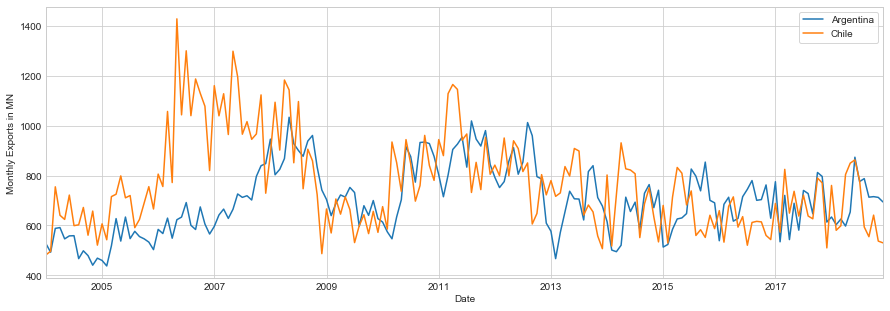

In [37]:
# Convert Spark dataframe to pandas dataframe and reindex using years and months
df = query.filter(query["PARTNER_ISO"].isin(["AR", "CL"])).toPandas()
df.index = pd.to_datetime(df["PERIOD"].astype(str), format="%Y%m")

# Visualize time series
plt.figure(figsize=(15,5))
df[df.PARTNER_ISO == "AR"]["IMPORTS_MN"].rename("Argentina")["2004":"2018"].plot()
df[df.PARTNER_ISO == "CL"]["IMPORTS_MN"].rename("Chile")["2004":"2018"].plot()
plt.xlabel("Date")
plt.ylabel("Monthly Exports in MN")
plt.legend(frameon=True)
plt.show()

### Finding trade volumnes based on product descriptions

In [ ]:
# TO BE DONE